In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])
# plt.style.use(['seaborn-notebook'])

In [3]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

from utils import spaths, dmaps
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import coord_grid

In [4]:
# datasets directory
ds_path = root / 'data'

In [5]:
print(f"Available datasets : {[ds.stem for ds in ds_path.iterdir() if ds.is_dir()]}")

Available datasets : ['Sin2', 'RQP4', 'LogSin2']


# Dataset

In [66]:
name_ds = 'RQP4'
dataset = getattr(datasets, name_ds)

In [67]:
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

In [68]:
train_ds = dataset(root / 'data')

## Path

In [10]:
times, path = torch.load(data_path / 'raw' / 'path.pt')
len(path)

800002

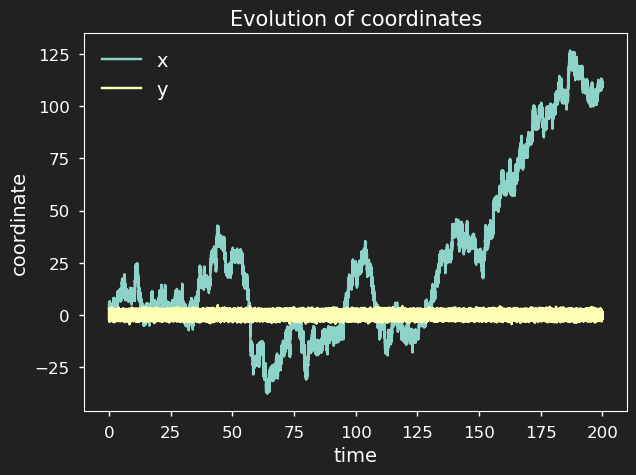

In [11]:
coords = plt.plot(times, path)
plt.xlabel("time")
plt.ylabel("coordinate", rotation=90)
plt.title("Evolution of coordinates")
plt.legend(coords, ("x", "y"))
plt.show()

In [12]:
colors = ['#8dd3c7', '#feffb3', '#fa8174']
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

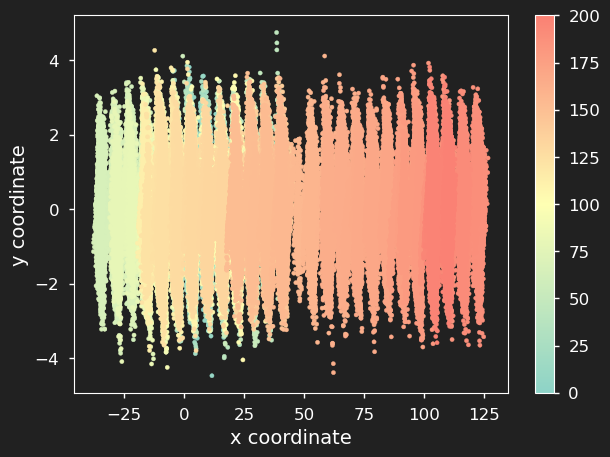

In [13]:
plt.scatter(*path.T, c=times, cmap=cmap1)
plt.xlabel("x coordinate")
plt.ylabel("y coordinate", rotation=90)
plt.colorbar()
plt.show()

## Training dataset

In [15]:
np.any(train_ds == np.nan)

False

In [16]:
len(train_ds.slow_proj)

2680

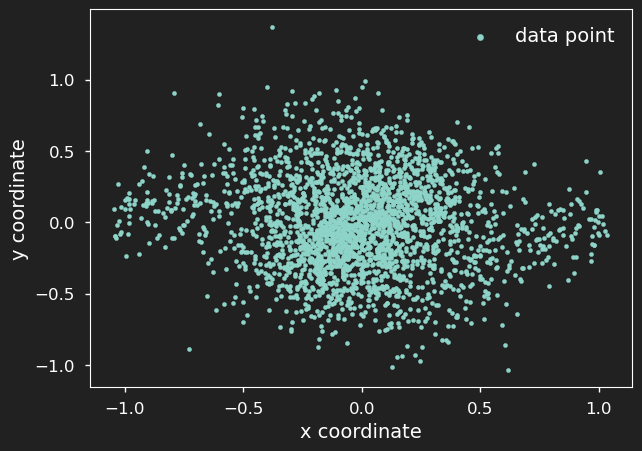

In [17]:
plt.scatter(*train_ds.data.T, label="data point")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate", rotation=90)
plt.legend()
plt.show()

### Timescale spearation

In [18]:
covis = np.array([covi.detach().numpy() for dp, covi, *rest in train_ds])
covis.shape

(2680, 2, 2)

In [19]:
data_evals, data_evecs = zip(*[np.linalg.eigh(covi) for covi in covis])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = 1/np.array(data_evals), np.array(data_evecs)

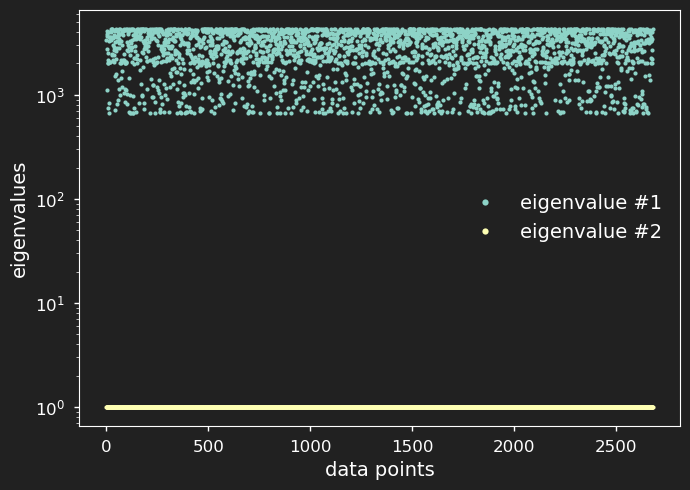

In [20]:
fig, ax = plt.subplots()
for n, e_val in enumerate(data_evals.T):
    ax.plot(e_val/data_evals.T[-1], 'o', label=f"eigenvalue #{n+1}")
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Slow manifold

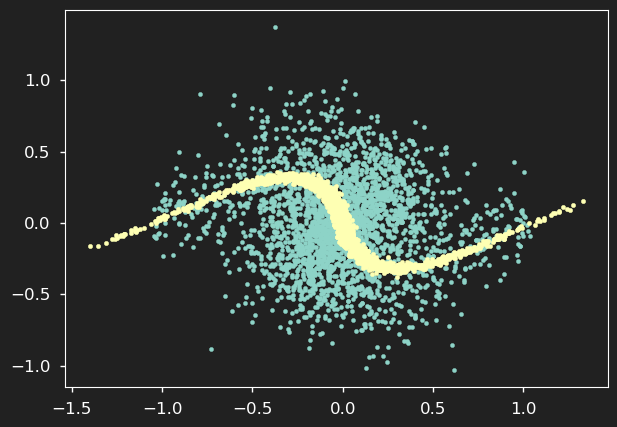

In [21]:
plt.scatter(*train_ds.data.T, label="data point")
plt.scatter(*train_ds.slow_proj.T, s=10, label="slow manifold");

# Trained models

In [69]:
model_types = ['mah']

In [70]:
series_list = []
for file in os.listdir(model_path):
    fpath = Path(file)
    if fpath.suffix == '.pt' and any(mt in fpath.stem for mt in model_types):
        model_data = torch.load(model_path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
#         par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
        pruning = model_data['info']['config'].get('pruning')
#         par_dict['sparsity'] = model_data['best']['sparsity'] if pruning else 0.0
        par_dict['valid_loss'] = model_data['history']['valid_losses'][model_data['best']['epoch']-1]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,features,valid_loss
model_id,,,
mah_tanh_0,300,"[4, 8, 1, 8, 4]",0.8
mah_tanh_1,250,"[4, 16, 1, 16, 4]",0.78
mah_tanh_2,800,"[4, 32, 1, 32, 4]",0.83
mah_tanh_3,350,"[4, 8, 8, 1, 8, 8, 4]",0.81
mah_tanh_4,600,"[4, 16, 8, 1, 8, 16, 4]",0.78
mah_tanh_5,800,"[4, 32, 16, 1, 16, 32, 4]",0.75
mah_tanh_5a,1500,"[4, 32, 16, 1, 16, 32, 4]",0.84
mah_tanh_pruned_0,35,"[4, 8, 4, 1, 4, 8, 4]",1.2
mah_tanh_pruned_1,350,"[4, 32, 16, 1, 16, 32, 4]",0.74


## Loss

In [71]:
model_id = 'mah_tanh_pruned_2'

In [72]:
model_data = torch.load(model_path / f'{model_id}.pt')
print(f'{model_data.keys() = }')

model_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [73]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

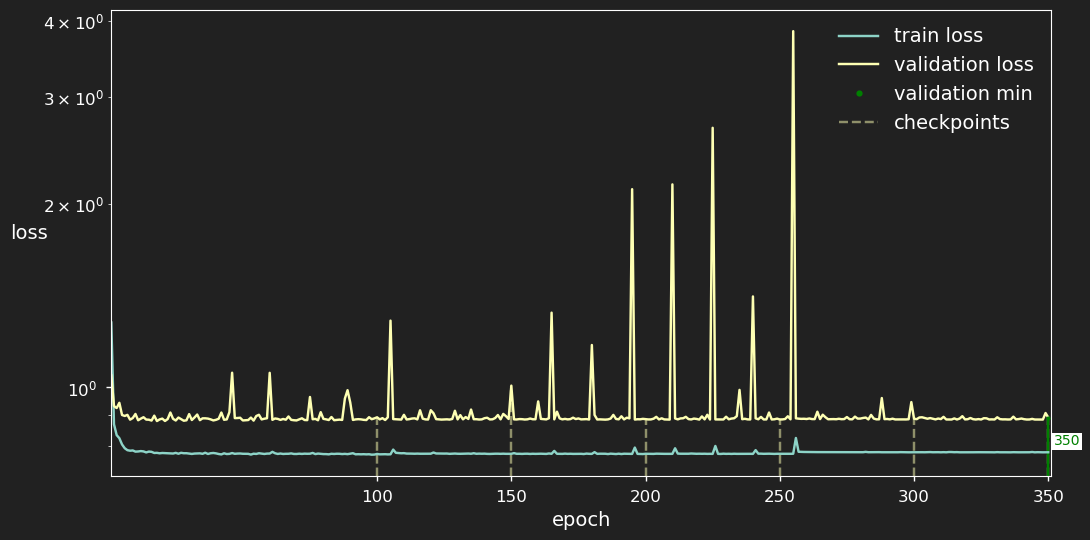

In [74]:
fig, ax = plt.subplots(figsize=(11,5.5))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .9*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids)
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Load Model

In [75]:
model = getattr(models, model_data['info']['architecture'])(**model_data['info']['arguments'])
model

MahalanobisAutoencoder(
  (encoder): Sequential(
    (layer1): Linear(in_features=4, out_features=32, bias=True)
    (activation1): Tanh()
    (layer2): Linear(in_features=32, out_features=32, bias=True)
    (activation2): Tanh()
    (layer3): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (layer1): Linear(in_features=1, out_features=32, bias=True)
    (activation1): Tanh()
    (layer2): Linear(in_features=32, out_features=32, bias=True)
    (activation2): Tanh()
    (layer3): Linear(in_features=32, out_features=4, bias=True)
  )
  (mah_loss): MahalanobisLoss()
)

In [76]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [77]:
check_epoch = 'best'

In [78]:
if check_epoch == 'best':
    state_dict = remove_mask(model_data['best']['model_dict'])
#     state_dict = model_data['best']['model_dict']
    check_epoch = best_epoch
else:
    check_dict = torch.load(model_path / f'{model_id}' / f'state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [79]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [80]:
model.eval();

## Reconstruction visualization

In [81]:
rec_train_data = model(train_ds.data)
train_data_np = train_ds.data.detach().numpy()
rec_train_data_np = rec_train_data.detach().numpy()

In [84]:
plt.scatter(*train_data_np.T)
plt.scatter(*rec_train_data_np.T);

TypeError: scatter() got multiple values for argument 'c'

## Encoder accuracy

In [85]:
test_ds = dataset(root / 'data', train=False)
test_data_np = test_ds.data.detach().numpy()

In [86]:
# plt.scatter(*test_data_np.T, s=3);

In [87]:
dt = train_ds.dt
sde = train_ds.system.sde
slow_map = train_ds.system.slow_map

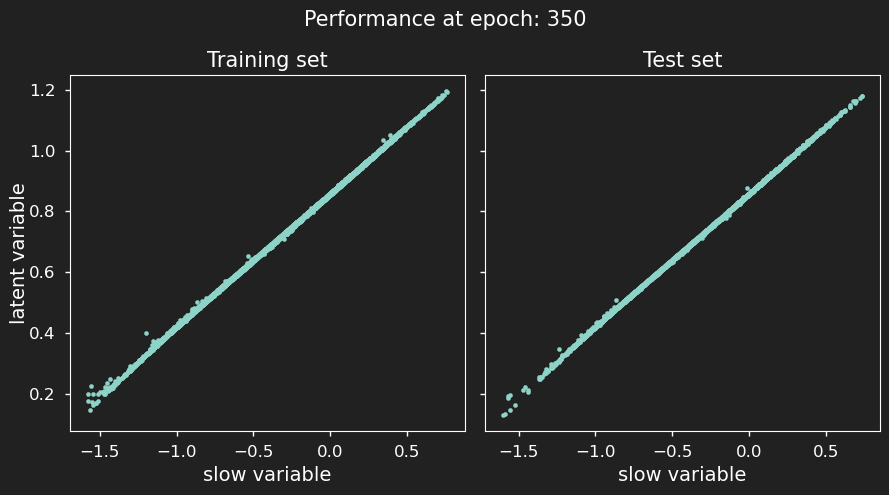

In [88]:
fig, axs = plt.subplots(ncols=2, figsize=(9,5), sharey=True)

train_test_data = [train_ds.data, test_ds.data]
for ax, data, title in zip(axs, train_test_data, ['Training set', 'Test set']):
    slow_var = slow_map(data.detach().numpy().T)
    lat_var = model.encoder(data).detach().numpy()
    try:
        ax.scatter(slow_var, lat_var.T)
    except ValueError:
        print('Latent layer too large.')
        plt.close(fig)
    
    ax.set_title(f'{title}')
    ax.set_xlabel('slow variable')
axs[0].set_ylabel('latent variable', labelpad=0)

fig.tight_layout()

fig.suptitle(f'Performance at epoch: {check_epoch}', size=15)
fig.subplots_adjust(top=0.85)
fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

In [62]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [50]:
start = test_data_np[1000:1002]
tspan = (0, 1)

test_sol = em.solve(sde, start, tspan, dt)

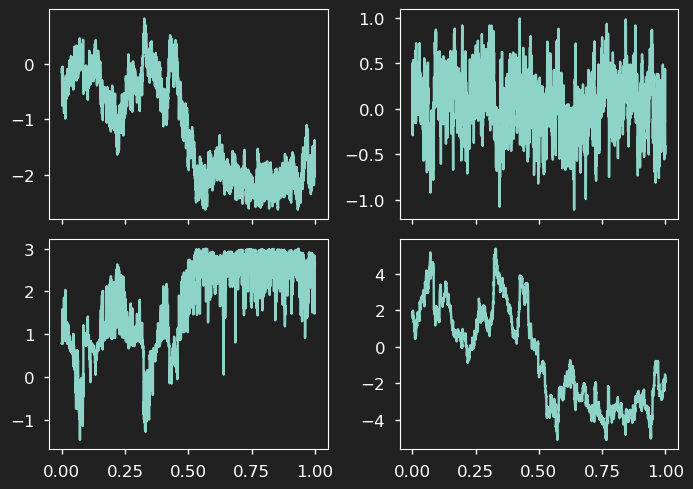

In [51]:
test_path = test_sol.p[0].T
t = np.linspace(*tspan, len(test_path.T))

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True)

axs[0,0].plot(t, test_path[0]);
axs[0,1].plot(t, test_path[1]);

test_path_t = torch.from_numpy(test_path.T).to(dtype=torch.float)
lat_var = model.encoder(test_path_t).detach().numpy()
axs[1,0].plot(t, lat_var);
axs[1,1].plot(t, slow_map(test_path))

fig.tight_layout()
plt.show(fig)

In [99]:
train_data = train_ds.data
Y = model(train_data)[1].detach().numpy()
train_data_np= train_data.detach().numpy()
train_means = np.mean(train_data_np, axis=0)
train_stds = np.std(train_data_np, axis=0)

In [100]:
max_deg = 1
powers = [
    (p1, p2)
    for p2 in range(max_deg+1) for p1 in range(max_deg+1)
    if p1 + p2 > 0 and p1 + p2 <= max_deg
]
basis = [
    f"x^{p1}" if p2==0 else (f"y^{p2}" if p1== 0 else f"x^{p1}y^{p2}")
    for p1, p2 in powers
]

x, y = train_data.T
X = np.zeros((len(powers)+1, len(train_data)))
for idx, (n, m) in enumerate(powers):
    X[idx] = x**n * y**m
X[-1] = np.log(x + 3)
basis.append("log(x)")
X = pd.DataFrame(X.T, columns=basis)
X.head()

,x^1,y^1,log(x)
0,-0.961983,-0.236718,0.711978
1,0.818180,0.605251,1.339774
2,-0.268234,0.190552,1.004948
3,1.224008,0.750810,1.440784
4,1.455687,0.988548,1.494181


In [101]:
alpha_list = np.arange(0.001, 0.1, 0.001)
results = dmaps.lasso_adm(X, Y, alpha_list, rng)
results

,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010,...,0.090,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099
x^1,0.279367,0.308775,0.308220,0.307659,0.307096,0.306533,0.305970,0.305407,0.304844,0.304280,...,0.259243,0.258680,0.258116,0.257553,0.256990,0.256427,0.255863,0.255300,0.254737,0.254173
y^1,0.113922,0.117927,0.117379,0.116837,0.116296,0.115755,0.115215,0.114674,0.114134,0.113593,...,0.070328,0.069787,0.069246,0.068706,0.068165,0.067625,0.067084,0.066544,0.066003,0.065463
log(x),0.088964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
train_score,0.997929,0.997027,0.996995,0.996949,0.996891,0.996819,0.996735,0.996637,0.996526,0.996403,...,0.944289,0.943110,0.941917,0.940712,0.939494,0.938262,0.937018,0.935761,0.934490,0.933207
test_score,0.997803,0.996724,0.996653,0.996569,0.996472,0.996362,0.996239,0.996104,0.995956,0.995795,...,0.941571,0.940377,0.939169,0.937949,0.936715,0.935470,0.934211,0.932939,0.931655,0.930358


In [102]:
X.describe()

,x^1,y^1,log(x)
count,2.680000e+03,2.680000e+03,2680.000000
mean,1.533547e-07,5.153673e-07,1.030370
std,1.000187e+00,1.000187e+00,0.392422
min,-2.265648e+00,-2.953966e+00,-0.308766
25%,-7.950016e-01,-6.401453e-01,0.790727
50%,1.009066e-01,1.791369e-01,1.131694
75%,8.726342e-01,7.508699e-01,1.353935
max,1.804869e+00,2.201757e+00,1.569630
